In [1]:
!pip install pandas numpy requests matplotlib scipy

import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt


  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/86/41/585a168330ff063014880a80d744219dbf1dd7a1c706e75ab3425a987384/pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata
  Using cached pandas-2.3.3-cp312-cp312-win_amd64.whl.metadata (19 kB)
  Obtaining dependency information for numpy from https://files.pythonhosted.org/packages/3d/a8/566578b10d8d0e9955b1b6cd5db4e9d4592dd0026a941ff7994cedda030a/numpy-2.3.4-cp312-cp312-win_amd64.whl.metadata
  Using cached numpy-2.3.4-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Obtaining dependency information for requests from https://files.pythonhosted.org/packages/1e/db/4254e3eabe8020b458f1a747140d32277ec7a271daf1d235b70dc0b4e6e3/requests-2.32.5-py3-none-any.whl.metadata
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/31/3c/80816f027b3a4a28cd2a0a6ef7f89a2db22310e945cd886ec25bfb399221/matplotlib-3.10.7-c


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
def get_event_laps(year=2024, round_number=1):
    url = f"https://api.openf1.org/v1/laps?year={year}&round={round_number}"
    df = pd.read_json(url)
    return df

laps = get_event_laps(2024, 1)
laps.head()


""


In [3]:
def get_weather(lat, lon):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={lat}&longitude={lon}&hourly=temperature_2m,wind_speed_10m,precipitation"
    data = requests.get(url).json()
    return pd.DataFrame(data["hourly"])

# Example: Bahrain coordinates
weather = get_weather(26.0325, 50.5106)
weather.head()


,time,temperature_2m,wind_speed_10m,precipitation
0,2025-11-15T00:00,25.2,11.9,0.0
1,2025-11-15T01:00,25.2,12.4,0.0
2,2025-11-15T02:00,25.3,12.8,0.0
3,2025-11-15T03:00,25.4,13.3,0.0
4,2025-11-15T04:00,25.5,14.2,0.0


In [4]:
# Example degradation coefficients per compound (seconds/lap/lap)
tyre_deg = {
    "SOFT": 0.060,
    "MEDIUM": 0.045,
    "HARD": 0.035
}

# Base tyre pace deltas
tyre_base = {
    "SOFT": 0.0,
    "MEDIUM": 0.8,
    "HARD": 1.4
}

def tyre_time(compound, lap_number, track_temp):
    deg = tyre_deg[compound] * lap_number
    temp_factor = (track_temp - 25) * 0.005  # 0.5% per 1°C above optimal
    return tyre_base[compound] + deg + temp_factor


In [5]:
def fuel_lap_time(fuel_kg):
    return fuel_kg * 0.035


In [6]:
def simulate_stint(compound, laps, start_fuel, track_temp):
    times = []
    fuel = start_fuel

    for i in range(laps):
        tire = tyre_time(compound, i, track_temp)
        fuel_effect = fuel_lap_time(fuel)
        total = tire + fuel_effect

        times.append(total)
        fuel -= 1.7  # ~1.7 kg/lap

    return np.array(times)


In [7]:
def simulate_race(total_laps, pit_lap_1, pit_lap_2=None):
    track_temp = float(weather["temperature_2m"][0])

    # Assume compound order: MEDIUM → HARD (1-stop baseline)
    stints = []
    fuel = total_laps * 1.7

    if pit_lap_2:   # 2-stop
        stint_1 = simulate_stint("MEDIUM", pit_lap_1, fuel, track_temp)
        stint_2 = simulate_stint("MEDIUM", pit_lap_2 - pit_lap_1, fuel - pit_lap_1*1.7, track_temp)
        stint_3 = simulate_stint("HARD", total_laps - pit_lap_2, fuel - pit_lap_2*1.7, track_temp)
        total_time = stint_1.sum() + stint_2.sum() + stint_3.sum() + 22.0*2  # pit loss
    else:           # 1-stop
        stint_1 = simulate_stint("MEDIUM", pit_lap_1, fuel, track_temp)
        stint_2 = simulate_stint("HARD", total_laps - pit_lap_1, fuel - pit_lap_1*1.7, track_temp)
        total_time = stint_1.sum() + stint_2.sum() + 22.0  # pit loss

    return total_time


In [8]:
total_laps = 57
results = []

for pit in range(8, 30):
    t = simulate_race(total_laps, pit)
    results.append((pit, t))

results_df = pd.DataFrame(results, columns=["pit_lap", "total_time"])
results_df.sort_values("total_time").head()


,pit_lap,total_time
21,29,214.3105
20,28,214.6305
19,27,215.0305
18,26,215.5105
17,25,216.0705


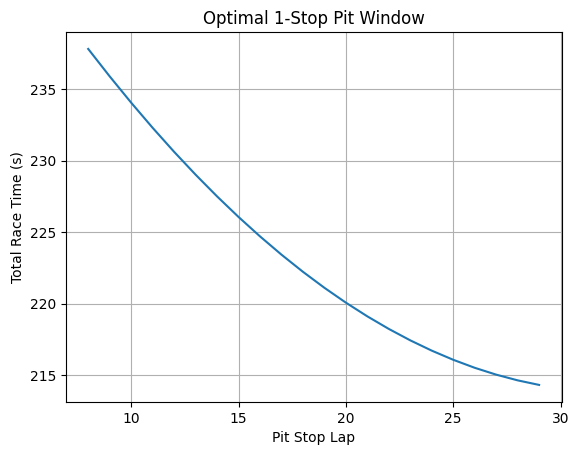

In [9]:
plt.plot(results_df.pit_lap, results_df.total_time)
plt.xlabel("Pit Stop Lap")
plt.ylabel("Total Race Time (s)")
plt.title("Optimal 1-Stop Pit Window")
plt.grid(True)
plt.show()